# Moderate collection preprocessing

# Summary of what works

## Dataset

Dataset class called 'ModerateDataset' created

- Allows for all Moderate collection images, colour and depth, to be read into Pytorch Tensors
- Returns these two tensors as col_img and depth_img

## Dataloader

Dataloader created that allows for the batching and shuffling of Moderate collection images
- Allows a given batch size to be created
- Can be used to create training, validation and testing datasets based on instancing the ModerateDataset class (yet to be implemented)

# To be done

## Standardisation

- Method is avaliable in the lecture 8 notebook

## CNN model

- Code avaliable in both the lecture 8 notebook and via nick and kari's github pages
- CNN layers to be decided
- Training with dataloader to be done (without callbacks first and then with)

## Depth conversion

- Formula known but not implemented in code, this will be worked on in later weeks as it is not as time sensitive as other matters above


## Required imports

In [1]:
import torch
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
from Functions import import_raw_colour_image, import_raw_depth_image, show_depth_image, show_img
import os
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

plt.ion()   # interactive mode

# Reading in data descriptions from csv and saving information

In [2]:
import csv
with open('data_descriptions.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    count = 0
    for row in spamreader:
        if count == 0:
            folder_names = row
        else:
            num_files = row
        count = 1

Converting the numbers read in from the csv to integers

In [3]:
for i in range(0,len(num_files)):
    num_files[i] = int(num_files[i])
# folder_names

Creating the filenames for each image e.g. 'colour_00020.raw', 'depth_03021.raw' for use in appending to filepaths

In [4]:
list_of_numbers = ["{0:05}".format(i) for i in range(1, sum(num_files)+1)]
colour_filenames = []
depth_filenames = []
for num in list_of_numbers:
    colour_filenames.append(f"colour_{num}.raw")
    depth_filenames.append(f"depth_{num}.raw")

# Moderate dataset

Creating a dataset class called 'ModerateDataset' that will allow the reading of images from Moderate Collection and their conversion to Pytorch Tensors.

In [5]:
class ModerateDataset(Dataset):

    def __init__(self, col_dir='', depth_dir='', transform=transforms.ToTensor(),trans_on=False):
        self.path_names = {}
        for folder in folder_names:
            self.path_names[f"{folder}"] = {}
        for folder in folder_names:
            self.path_names[f'{folder}']['colour'] = {}
            self.path_names[f'{folder}']['depth'] = {}
        for i in range(1, num_files[0]):
            self.path_names['Sunny']['colour'][f"{i}"] = {}
            self.path_names['Sunny']['depth'][f"{i}"] = {}
        print("*************MAKE SURE THE PATH FILE IN THE FOR LOOP IS THE BASE IMAGE DIRECTORY ON YOUR COMPUTER**************")
        count = 0
        for folder in folder_names:
            for i in range(0, num_files[folder_names.index(folder)]):
                self.path_names[f'{folder}']['colour'][f'{i+1}'] = Path(f"C:/Users/Ben/OneDrive - Bournemouth University/Computer Vision/Moderate collection/{folder}/colour/{colour_filenames[count+i]}")
                self.path_names[f'{folder}']['depth'][f'{i+1}'] = Path(f"C:/Users/Ben/OneDrive - Bournemouth University/Computer Vision/Moderate collection/{folder}/depth/{depth_filenames[count+i]}")
            count = count + num_files[folder_names.index(folder)]
        
        self.transform = transform
        self.col_dir = col_dir
        self.depth_dir = depth_dir
        self.trans_on = trans_on

    def __getitem__(self,idx):
        if idx == 0:
            
            self.col_dir = self.path_names[f'{folder_names[0]}']['colour'][f'{idx+1}']
            self.depth_dir = self.path_names[f'{folder_names[0]}']['depth'][f'{idx+1}']
        
        if (idx>0 and idx <= num_files[0]):  ## 1-500

            self.col_dir = self.path_names[f'{folder_names[0]}']['colour'][f'{idx}']
            self.depth_dir = self.path_names[f'{folder_names[0]}']['depth'][f'{idx}']

        elif (idx > num_files[0] and idx < (sum(num_files[:2])+1)): ## 501 - 1500

            self.col_dir = self.path_names[f'{folder_names[1]}']['colour'][f'{idx-num_files[0]}']
            self.depth_dir = self.path_names[f'{folder_names[1]}']['depth'][f'{idx-num_files[0]}']

        elif (idx > sum(num_files[:2]) and idx < (sum(num_files[:3])+1) ): ## 1501 - 2600

            self.col_dir = self.path_names[f'{folder_names[2]}']['colour'][f'{idx-sum(num_files[:2])}'] # -1500
            self.depth_dir = self.path_names[f'{folder_names[2]}']['depth'][f'{idx-sum(num_files[:2])}']

        elif (idx > sum(num_files[:3]) and idx < (sum(num_files[:4])+1) ): ## 2601 - 5600

            self.col_dir = self.path_names[f'{folder_names[3]}']['colour'][f'{idx-sum(num_files[:3])}'] #-2600
            self.depth_dir = self.path_names[f'{folder_names[3]}']['depth'][f'{idx-sum(num_files[:3])}']
            
        elif (idx > sum(num_files[:4]) and idx < (sum(num_files[:5])+1) ): ## 5601 - 7857

            self.col_dir = self.path_names[f'{folder_names[4]}']['colour'][f'{idx-sum(num_files[:4])}'] # -5600
            self.depth_dir = self.path_names[f'{folder_names[4]}']['depth'][f'{idx-sum(num_files[:4])}']

        elif (idx > sum(num_files)):
            raise NameError('Index outside of range')

        col_img = import_raw_colour_image(self.col_dir)
        depth_img = import_raw_depth_image(self.depth_dir)
        if self.trans_on == True:
            col_img = torch.from_numpy(np.flip(col_img,axis=0).copy()) # apply any flip transform
            depth_img = torch.from_numpy(np.flip(depth_img,axis=0).copy()) # apply any flip transform
            col_img = col_img.transpose(0,2)
            col_img = col_img.transpose(1,2)
        return col_img, depth_img
    
    def __len__(self):
        return sum(num_files)



## Example instancing of the 'ModerateDataset' class.
- trans_on is a Bool toggle allowing for images to be returned as numpy arrays (false) or Pytorch tensors (True).
- The show_img and show_depth_img functions only work with numpy arrays.
## ***BEWARE***
- trans_on is False by default so numpy arrays are returned

In [6]:
sData = ModerateDataset(trans_on=True)

*************MAKE SURE THE PATH FILE IN THE FOR LOOP IS THE BASE IMAGE DIRECTORY ON YOUR COMPUTER**************


In [7]:
example = sData[0] # 1 here is the index of the image in the dataset (1-500:Sunny, 501-1500:Snowy etc... see conditions.txt)

In [8]:
example_images = sData[0]

In [9]:
example[0].shape

torch.Size([720, 1280, 3])

In [10]:
## Show funs will not work with pytorch tensors!!!
# show_img(example[0], figsize=(8,8))
# show_depth_image(example[1])

# Creating a dataloader
## Beware 2.0
- From here onwards, Pytorch tensors are required so change trans_on to True

# TESTING

# END OF TESTING

In [12]:
img_dataloader = DataLoader(sData, batch_size=4, shuffle=True, num_workers=0)
x,y = next(iter(img_dataloader))


In [13]:
x,y = next(iter(img_dataloader))

In [14]:
x.shape

torch.Size([4, 720, 1280, 3])

In [15]:
y.shape

torch.Size([4, 720, 1280])

## Attempt to create image viewing functions for the tensor objects
- From here on, the code is not operational and should be omitted in any implementations

In [16]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(0,1,2)), interpolation='nearest')

In [17]:
idx = [i for i in range(x[0].size(0)-1, -1, -1)]
idx = torch.LongTensor(idx)
inverted_tensor = x[0].index_select(0, idx)

In [18]:
inverted_tensor.shape

torch.Size([720, 1280, 3])

In [19]:
#torch.flip(inverted_tensor,[0,1])

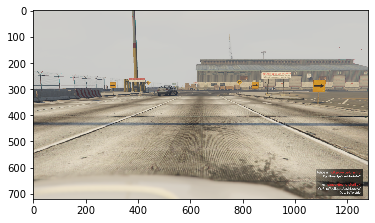

In [20]:
show(torch.flip(inverted_tensor,[1,2])) ## correct colours but horizontally flipped

In [21]:
idx = [i for i in range(y[0].size(0)-1, -1, -1)]
idx = torch.LongTensor(idx)
depth_inv = y[0].index_select(0, idx)

In [22]:
depth_inv.shape

torch.Size([720, 1280])

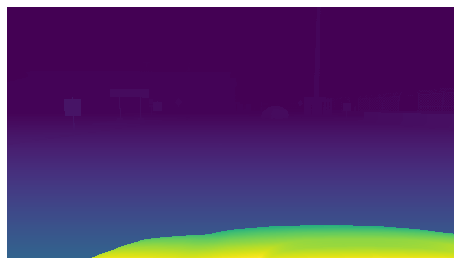

In [23]:
show_depth_image(depth_inv)

In [24]:
inv_idx = torch.arange(x[0].size(0)-1, -1, -1).long()
# or equivalently torch.range(tensor.size(0)-1, 0, -1).long()
inv_tensor = x[0].index_select(0, inv_idx)
# or equivalently
inv_tensor = x[0][inv_idx]

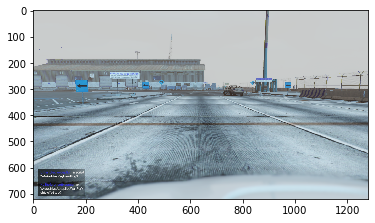

In [25]:
show(inv_tensor)